### 1. Import the Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

### 2. Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


### 3. Data Loading and Processing

In [3]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length=15, transform=None):
        """
        root_dir: path of the parent directory that contains processed frames/images.
        sequence_length: the number of frames in each subsequence.
        transforms: augmentations applied to the frames (can be none or more).
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}

        # Parse through categories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            # if not os.path.isdir(category_path):
            #     continue
            self.class_mapping[label] = category
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path): # check (folder also contain some json)
                    frames = sorted(os.listdir(subfolder_path))

                    # Create subsequences from frames
                    for start_idx in range(0, len(frames) - sequence_length + 1, sequence_length):  # (0, 450-15+1, 15)
                        subsequence_frames = frames[start_idx:start_idx + sequence_length]          # (0, 0+15), then (15, 30) and so on.
                        if len(subsequence_frames) == sequence_length:
                            self.data.append((subfolder_path, subsequence_frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        sequence = []
        for frame_file in frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                img = Image.open(frame_path).convert("L")
                if self.transform:
                    img = self.transform(img)

                img = img.view(-1)
                sequence.append(img)

            except Exception as e:
                # Found some corrupted image in the folders
                print(f"Skipping image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))

        # Stack frames into tensor
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


- No image resizing is done because the processed frames are of size 64x64.
- Images are converted to Grayscale (64x64=4096 pixels) since it will save some computation time (and the images are also grayscale so we don't lose any information). For RGB the number of pixels will be 3 x 4096.

#### Define augmentations

In [4]:
# Define augmentations
transform = transforms.Compose([
    
    # RandomHorizontalFlip(p=0.5),
    # RandomRotation(degrees=15),
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    
    transforms.ToTensor(),                             
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Taking the sequence length because I observed that in some of the categories like jogging, the first 7-8 frames are empty and till the 40-45th frames we get a complete motion i.e. person comes in running in the frame and then goes out after that the frames are again empty till the person again comes from the opposite direction.

In [5]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 16
train_ratio = 0.8  # 80% for train 20% for val

In [6]:
# Load the whole dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset into train and val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 6150
Train set size: 4920
Validation set size: 1230


In [7]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [8]:
# reverse mapping of the dataclasses
reverse_mapping = {val:key for key,val in dataset.class_mapping.items()}
reverse_mapping

{'boxing': 0,
 'handclapping': 1,
 'handwaving': 2,
 'jogging': 3,
 'running': 4,
 'walking': 5}

#### Visualize dataset

In [9]:
def visualize_sequences(dataset, category_label, num_sequences=3, sequence_length=15):
    """
    Visualizes the first num_sequences sequences for a given category label.
    """
    sequences_shown = 0
    
    plt.figure(figsize=(15, num_sequences * 3))
    for i in range(len(dataset)):
        sequence, label = dataset[i]
        if label == category_label:
            for frame_idx in range(sequence_length):
                plt.subplot(num_sequences, sequence_length, sequences_shown * sequence_length + frame_idx + 1)
                frame = sequence[frame_idx].view(64, 64).cpu().numpy()
                plt.imshow(frame, cmap="gray")
                plt.axis("off")
            
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                break

    plt.suptitle(f"Sequences for category label: {category_label}", fontsize=16)
    plt.show()

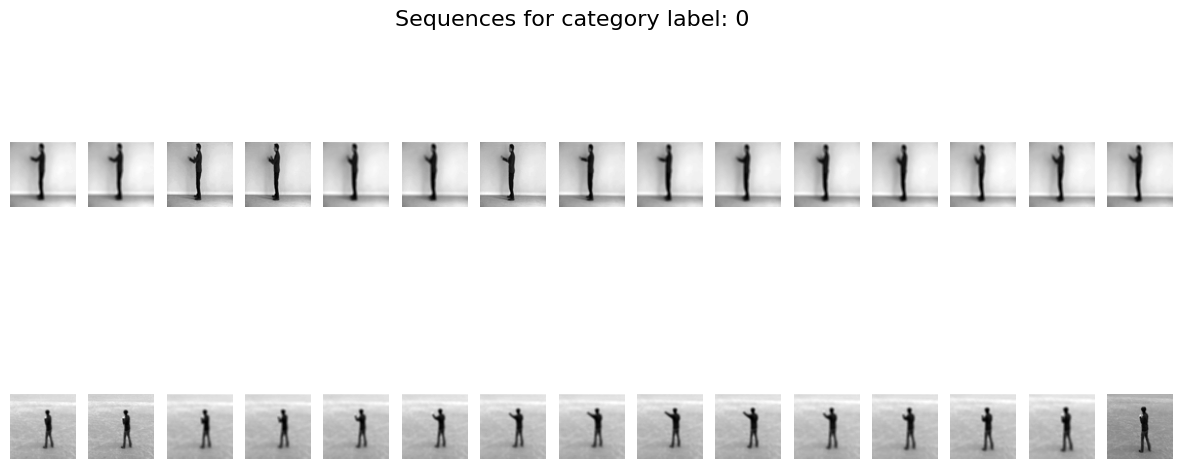

In [10]:
# Visualize sequences for given category label
category_name = 'boxing'
visualize_sequences(val_dataset, category_label=reverse_mapping[category_name], num_sequences=2, sequence_length=15)

### Training and Validation Code

This is the same code as used in the previous assignments with minor changes and integration of 'Weigths and Biases' for logging of metrics.

In [11]:
def train_nn(model, train_loader, criterion, optimizer, device, model_type=None):
    """Train  model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        if model_type == 'convlstm':
            inputs = inputs.view(-1, 45, 1, 64, 64) #height, width
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device, model_type=None):
    """Evaluate the model after each epoch."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            if model_type == 'convlstm':
                inputs = inputs.view(-1, 45, 1, 64, 64) # height, width
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5,
                 project='lstm_training', name='test_run', model_type=None):
    """Train and evaluate the model for a given number of epochs with W&B logging"""

    # Initialize W&B logging
    wandb.init(project=project, name=name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device, model_type=model_type)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device, model_type=model_type)

        current_lr = scheduler.get_last_lr()[0]


        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print stats after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the LR scheduler
        scheduler.step()

    # End W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

#### Training Logs 

Training logs for the model can be found here: https://wandb.ai/ahmadjaved97/assignment-4?nw=nwuserahmadjaved97

### Result Visualization

In [12]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [13]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

### Load saved model

In [14]:
def load_model(model_path):
    model = torch.load(model_path)
    return model

#### LSTM  and LSTM Cell from Scratch

Inspired from 
1. https://github.com/hadi-gharibi/pytorch-lstm/blob/master/lstm.ipynb
2. https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch

both sources have highly similar code

In [15]:
### This works

class LSTMCell(nn.Module):
    """
    Custom LSTM Cell implementation from scratch
    
    Args:
    - input_size: Number of input features
    - hidden_size: Number of hidden units
    """
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # all gates weight combined into signle matrix
        # ih -> input_hidden
        # hh -> hidden_hidden
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))  
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        
        # Bias term
        self.bias_ih = nn.Parameter(torch.empty(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))
        
        # Initialize weights
        std = 1.0 / np.sqrt(self.hidden_size)
        nn.init.uniform_(self.weight_ih, -std, std)
        nn.init.uniform_(self.weight_hh, -std, std)
        nn.init.uniform_(self.bias_ih, -std, std)
        nn.init.uniform_(self.bias_hh, -std, std)
    
    def forward(self, x, hidden_state=None):
        """
        Forward pass for LSTM Cell
        """
        # Initialize hidden state if not provided
        if hidden_state is None:
            batch_size = x.size(0)
            h = x.new_zeros(batch_size, self.hidden_size)
            c = x.new_zeros(batch_size, self.hidden_size)
        else:
            h, c = hidden_state
        
        # Compute gate inputs
        gates = F.linear(x, self.weight_ih, self.bias_ih) + F.linear(h, self.weight_hh, self.bias_hh)
        
        # Split gates into 4 equal parts
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        # Apply activation
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        # new cell state
        new_c = (forgetgate * c) + (ingate * cellgate)
        
        # new hidden state
        new_h = outgate * torch.tanh(new_c)
        
        return new_h, new_c

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_first=True):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList()
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.lstm_cells.append(LSTMCell(layer_input_size, hidden_size))
        
        # Classification layer
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        if not self.batch_first:
            x = x.transpose(0, 1)
        
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states
        h_list = []
        c_list = []
        for _ in range(self.num_layers):
            h_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))
            c_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))


        all_h_states = []

        for t in range(seq_len):
            # Current input at time  t
            input_t = x[:, t, :]
            
            for layer in range(self.num_layers):
                cell = self.lstm_cells[layer]
                
                # Use previous layer hidden state as input
                h_prev = input_t if layer == 0 else h_list[layer-1]
                
                # Update hidden and cell states
                h_list[layer], c_list[layer] = cell(h_prev, (h_list[layer], c_list[layer]))
            
            
            all_h_states.append(h_list[-1])

        # Stack the hidden states for all time steps
        all_h_states = torch.stack(all_h_states, dim=1)  # Shape: [batch_size, seq_len, hidden_size]

        
        output = self.classifier(all_h_states)

        return output


Some help from
- https://discuss.pytorch.org/t/nn-lstm-using-custom-lstmcells/118645/2

### Pytorch LSTM Model

In [16]:
class CustomPLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomPLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            nn.LSTMCell(input_size if i == 0 else hidden_size, hidden_size) 
            for i in range(num_layers)
        ])
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        Returns:
            output: Output tensor of shape (batch_size, seq_len, output_size)
        """
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden and cell states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        # To store the output at each time step
        outputs = []
        
        for t in range(seq_len):
            # Extract the time step t input
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.lstm_cells[layer](
                    x_t, (h_t[layer], c_t[layer])
                )
                # The input to the next layer is the output of the current layer
                x_t = h_t[layer]
            
            # Pass the final layer's output through the fully connected layer
            output_t = self.fc(h_t[-1])
            outputs.append(output_t)
        
        # Stack the outputs to form the final output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs

### Pytorch GRU Model

In [17]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h_t[layer] = self.gru_cells[layer](x_t, h_t[layer])
                x_t = h_t[layer]
            
            output_t = self.fc(h_t[-1])
            outputs.append(output_t)
        
        # Stack the outputs to form the final output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs

### ConvLSTM from scratch

Inspired from

- https://github.com/rogertrullo/pytorch_convlstm/blob/master/conv_lstm.py

- https://github.com/Atcold/pytorch-CortexNet/blob/master/model/ConvLSTMCell.py

- https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582

In [18]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        # Gates: i, f, o, g
        self.conv = nn.Conv2d(
            input_channels + hidden_channels, 
            4 * hidden_channels, 
            kernel_size, 
            padding=self.padding, 
            bias=self.bias
        )

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Concatenate along channel dimension
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)

        # Split into gates
        i, f, o, g = torch.split(conv_output, self.hidden_channels, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        # Update cell state and hidden state
        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, height, width):
        h = torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device)
        return h, c


class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, num_classes, height, width, bias=True):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.height = height
        self.width = width

        # ConvLSTM layers
        self.layers = nn.ModuleList([
            ConvLSTMCell(
                input_channels=input_channels if i == 0 else hidden_channels[i - 1],
                hidden_channels=hidden_channels[i],
                kernel_size=kernel_size,
                bias=bias
            ) for i in range(num_layers)
        ])

        self.fc = nn.Linear(hidden_channels[-1] * height * width, num_classes)

    def forward(self, x):
        batch_size, seq_len, _, height, width = x.size()
        assert height == self.height and width == self.width, "Input size mismatch with initialized height and width."

        # Initialize hidden states for all layers
        hidden_states = [layer.init_hidden(batch_size, height, width) for layer in self.layers]

        # Process sequence through ConvLSTM layers
        for t in range(seq_len):
            current_input = x[:, t]
            for l, layer in enumerate(self.layers):
                hidden_states[l] = layer(current_input, hidden_states[l])
                current_input = hidden_states[l][0]  # Use the hidden state (h_t)

        # Last layer's hidden state at the last time step
        last_hidden_state = hidden_states[-1][0]
        return last_hidden_state

### Model ( Encoder + RNN + Classifier)

In [19]:
class ActionClassificationModel(nn.Module):
    def __init__(self, sequence_length, input_dim=64*64, num_layers=2, num_classes=6, rnn_module='scratch_lstm'):
        super(ActionClassificationModel, self).__init__()
        self.sequence_length = sequence_length
        self.rnn_module = rnn_module
        self.num_layers = num_layers

        # Encoder Block
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # RNN modules to be put here
        if self.rnn_module == 'scratch_lstm':
            # Custom LSTM Module
            self.rnn = LSTM(
                input_size=256 * 8 * 8,
                hidden_size=256,         
                num_layers=self.num_layers,           
                num_classes=256,    
                batch_first=True
            )
        elif self.rnn_module == 'custom_lstm':
            self.rnn = CustomPLSTM(
            input_size=256 * 8 * 8,  # Flattened size from encoder
            hidden_size=256,         # Hidden state size
            output_size=256,         # Output size per time step
            num_layers=self.num_layers             # Number of LSTM layers
            )

        elif self.rnn_module == 'gru':
            self.rnn = CustomGRU(
            input_size=256 * 8 * 8,  # Flattened size from encoder
            hidden_size=256,
            output_size=256,
            num_layers=self.num_layers
            )

        elif self.rnn_module == 'convlstm':
            self.rnn = ConvLSTM(
            input_channels=256,
            hidden_channels=[64, 64],  # Two layers with 64 channels each
            kernel_size=3,
            num_layers=self.num_layers,
            num_classes=num_classes,
            height=8,  # Adjusted based on encoder output size
            width=8
            )
        else:
            print("Error")

        # print("Conv lstm shape: ", self.rnn.shape)


        if self.rnn_module != 'convlstm':
            # Classifier
            self.classifier = nn.Sequential(
                nn.Conv1d(256, 128, kernel_size=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(128, num_classes)
            )
        else:

            # Custom classifier for ConvLSTM
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, num_classes)
            )

    # def forward(self, x):
    #     batch_size, seq_len, _ = x.size()
        
    #     # Reshape each frame
    #     x = x.view(batch_size * seq_len, 1, 64, 64)
    #     x = self.encoder(x)
    #     x = x.view(batch_size, seq_len, -1)
        
    #     # Recurrent Module
    #     x = self.rnn(x)  
        
    #     # print("Debug:", x.shape)
        
    #     # Classifier
    #     x = x.transpose(1, 2)
    #     x = self.classifier(x)
        
    #     return x
    def forward(self, x):
        batch_size, seq_len, *rest = x.size()

        # Handle reshaping based on input dimensions
        if len(rest) == 1:  # General RNN
            input_height, input_width = 64, 64
            x = x.view(batch_size * seq_len, 1, input_height, input_width)
        elif len(rest) == 3:  # ConvLSTM
            height, width = rest[1], rest[2]
            x = x.view(batch_size * seq_len, 1, height, width)

        x = self.encoder(x)
        # print("Encoder output shape:", x.shape)

        # print("Convlstm shape: ", x.shape)

        if self.rnn_module == 'convlstm':
            # For reshape and pass through ConvLSTM module
            _, channels, height, width = x.size()
            # seq_len = x.size(0) // batch_size
            x = x.view(batch_size, seq_len, channels, height, width)
            x = self.rnn(x)  
            # print("ConvLSTM/RNN output shape: ", x.shape)
            _, channels, height, width = x.size()
            sequence_length = height * width
            x = x.view(batch_size, channels, sequence_length)
            # print("Reshaped for Conv1d: ", x.shape)
        elif self.rnn_module in ['scratch_lstm', 'custom_lstm', 'gru']:
            # For other RNNs
            x = x.view(batch_size, seq_len, -1)
            x = self.rnn(x)
            x = x.transpose(1, 2)
            
        
        # if len(x.size()) > 2:
        #     x = x.view(batch_size, -1)
        # Classifier
        x = self.classifier(x)
        # print("Final classifier input shape:", x.shape)

    
        return x

### LSTM from Scratch training

In [20]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
# hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Schedussler
name = f"lstm_scratch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment-4'

#criterion
criterion = nn.CrossEntropyLoss()

In [21]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes, 
                                           num_layers=num_layers).to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [22]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  3%|█▊                                                   | 1/30 [02:29<1:12:15, 149.51s/it]

Epoch 1/30
Train Loss: 1.1546, Train Accuracy: 0.4039
Eval Loss: 1.0372, Eval Accuracy: 0.4618
Learning Rate: 0.001000


  7%|███▌                                                 | 2/30 [04:54<1:08:23, 146.56s/it]

Epoch 2/30
Train Loss: 0.9961, Train Accuracy: 0.5022
Eval Loss: 0.8852, Eval Accuracy: 0.5553
Learning Rate: 0.001000


 10%|█████▎                                               | 3/30 [07:18<1:05:30, 145.57s/it]

Epoch 3/30
Train Loss: 0.8410, Train Accuracy: 0.5776
Eval Loss: 0.7296, Eval Accuracy: 0.6520
Learning Rate: 0.001000


 13%|███████                                              | 4/30 [09:44<1:03:06, 145.64s/it]

Epoch 4/30
Train Loss: 0.7402, Train Accuracy: 0.6624
Eval Loss: 0.7683, Eval Accuracy: 0.6577
Learning Rate: 0.001000


 17%|████████▊                                            | 5/30 [12:08<1:00:28, 145.16s/it]

Epoch 5/30
Train Loss: 0.6691, Train Accuracy: 0.7120
Eval Loss: 0.6011, Eval Accuracy: 0.7268
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [14:32<57:58, 144.95s/it]

Epoch 6/30
Train Loss: 0.5348, Train Accuracy: 0.7661
Eval Loss: 0.4952, Eval Accuracy: 0.7707
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [16:57<55:28, 144.74s/it]

Epoch 7/30
Train Loss: 0.4916, Train Accuracy: 0.7874
Eval Loss: 0.4547, Eval Accuracy: 0.7894
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [19:21<53:01, 144.62s/it]

Epoch 8/30
Train Loss: 0.4426, Train Accuracy: 0.8000
Eval Loss: 0.4358, Eval Accuracy: 0.7829
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [21:46<50:36, 144.60s/it]

Epoch 9/30
Train Loss: 0.4361, Train Accuracy: 0.8065
Eval Loss: 0.5329, Eval Accuracy: 0.7585
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [24:10<48:12, 144.61s/it]

Epoch 10/30
Train Loss: 0.4171, Train Accuracy: 0.8091
Eval Loss: 0.4013, Eval Accuracy: 0.8041
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [26:36<45:53, 144.90s/it]

Epoch 11/30
Train Loss: 0.3600, Train Accuracy: 0.8354
Eval Loss: 0.3727, Eval Accuracy: 0.8146
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [29:01<43:29, 144.95s/it]

Epoch 12/30
Train Loss: 0.3313, Train Accuracy: 0.8447
Eval Loss: 0.3667, Eval Accuracy: 0.8122
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [31:26<41:04, 144.96s/it]

Epoch 13/30
Train Loss: 0.3193, Train Accuracy: 0.8528
Eval Loss: 0.3424, Eval Accuracy: 0.8268
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [33:51<38:37, 144.85s/it]

Epoch 14/30
Train Loss: 0.3139, Train Accuracy: 0.8539
Eval Loss: 0.3509, Eval Accuracy: 0.8260
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [36:15<36:11, 144.76s/it]

Epoch 15/30
Train Loss: 0.3062, Train Accuracy: 0.8581
Eval Loss: 0.3517, Eval Accuracy: 0.8236
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [38:40<33:46, 144.72s/it]

Epoch 16/30
Train Loss: 0.2837, Train Accuracy: 0.8697
Eval Loss: 0.3285, Eval Accuracy: 0.8309
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [41:04<31:20, 144.63s/it]

Epoch 17/30
Train Loss: 0.2731, Train Accuracy: 0.8722
Eval Loss: 0.3287, Eval Accuracy: 0.8358
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [43:29<28:55, 144.63s/it]

Epoch 18/30
Train Loss: 0.2623, Train Accuracy: 0.8738
Eval Loss: 0.3362, Eval Accuracy: 0.8301
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [45:54<26:31, 144.73s/it]

Epoch 19/30
Train Loss: 0.2563, Train Accuracy: 0.8766
Eval Loss: 0.3298, Eval Accuracy: 0.8374
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [48:18<24:06, 144.64s/it]

Epoch 20/30
Train Loss: 0.2487, Train Accuracy: 0.8795
Eval Loss: 0.3290, Eval Accuracy: 0.8398
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [50:44<21:44, 144.92s/it]

Epoch 21/30
Train Loss: 0.2321, Train Accuracy: 0.8886
Eval Loss: 0.3279, Eval Accuracy: 0.8366
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [53:10<19:21, 145.18s/it]

Epoch 22/30
Train Loss: 0.2302, Train Accuracy: 0.8896
Eval Loss: 0.3346, Eval Accuracy: 0.8382
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [55:35<16:55, 145.13s/it]

Epoch 23/30
Train Loss: 0.2294, Train Accuracy: 0.8915
Eval Loss: 0.3414, Eval Accuracy: 0.8341
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [57:59<14:29, 144.96s/it]

Epoch 24/30
Train Loss: 0.2212, Train Accuracy: 0.8951
Eval Loss: 0.3402, Eval Accuracy: 0.8415
Learning Rate: 0.000063


 83%|███████████████████████████████████████████▎        | 25/30 [1:00:26<12:08, 145.65s/it]

Epoch 25/30
Train Loss: 0.2189, Train Accuracy: 0.8951
Eval Loss: 0.3396, Eval Accuracy: 0.8480
Learning Rate: 0.000063


 87%|█████████████████████████████████████████████       | 26/30 [1:02:51<09:41, 145.38s/it]

Epoch 26/30
Train Loss: 0.2071, Train Accuracy: 0.9022
Eval Loss: 0.3461, Eval Accuracy: 0.8366
Learning Rate: 0.000031


 90%|██████████████████████████████████████████████▊     | 27/30 [1:05:16<07:15, 145.18s/it]

Epoch 27/30
Train Loss: 0.2067, Train Accuracy: 0.9022
Eval Loss: 0.3402, Eval Accuracy: 0.8472
Learning Rate: 0.000031


 93%|████████████████████████████████████████████████▌   | 28/30 [1:07:40<04:49, 144.95s/it]

Epoch 28/30
Train Loss: 0.2068, Train Accuracy: 0.9047
Eval Loss: 0.3466, Eval Accuracy: 0.8496
Learning Rate: 0.000031


 97%|██████████████████████████████████████████████████▎ | 29/30 [1:10:06<02:25, 145.31s/it]

Epoch 29/30
Train Loss: 0.2019, Train Accuracy: 0.9063
Eval Loss: 0.3534, Eval Accuracy: 0.8463
Learning Rate: 0.000031


100%|████████████████████████████████████████████████████| 30/30 [1:12:33<00:00, 145.11s/it]

Epoch 30/30
Train Loss: 0.1965, Train Accuracy: 0.9063
Eval Loss: 0.3522, Eval Accuracy: 0.8504
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▃▄▅▆▇▇▇▆▇▇▇██████████████████
eval_loss,█▆▅▅▄▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▅▅▆▆▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▇▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.85041
eval_loss,0.35222
learning_rate,3e-05
train_accuracy,0.9063


In [23]:
save_path = "./saved_models/lstm_scratch.pth"
torch.save(model, save_path)

/tmp/ipykernel_2697254/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


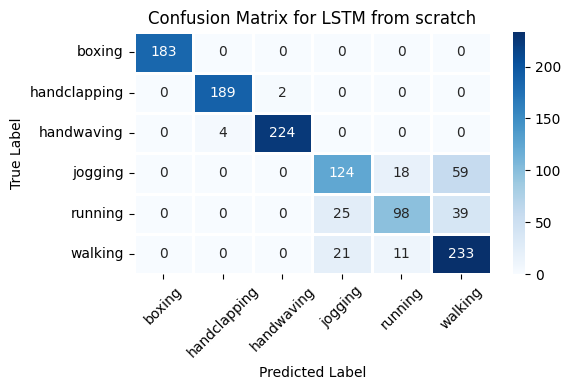

In [24]:
model = load_model("./saved_models/lstm_scratch.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="LSTM from scratch")

#### Pytorch LSTM Training

In [20]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
# hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"lstm_pytorch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment-4'

#criterion
criterion = nn.CrossEntropyLoss()

In [21]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes,num_layers=num_layers, rnn_module='custom_lstm').to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [22]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  3%|█▊                                                   | 1/30 [02:25<1:10:29, 145.84s/it]

Epoch 1/30
Train Loss: 1.1564, Train Accuracy: 0.4063
Eval Loss: 1.0210, Eval Accuracy: 0.4602
Learning Rate: 0.001000


  7%|███▌                                                 | 2/30 [04:49<1:07:24, 144.44s/it]

Epoch 2/30
Train Loss: 0.9533, Train Accuracy: 0.4937
Eval Loss: 0.8886, Eval Accuracy: 0.5276
Learning Rate: 0.001000


 10%|█████▎                                               | 3/30 [07:13<1:04:58, 144.38s/it]

Epoch 3/30
Train Loss: 0.8484, Train Accuracy: 0.5669
Eval Loss: 0.7951, Eval Accuracy: 0.6423
Learning Rate: 0.001000


 13%|███████                                              | 4/30 [09:37<1:02:24, 144.01s/it]

Epoch 4/30
Train Loss: 0.7176, Train Accuracy: 0.6801
Eval Loss: 0.7912, Eval Accuracy: 0.6293
Learning Rate: 0.001000


 17%|█████████▏                                             | 5/30 [12:00<59:56, 143.84s/it]

Epoch 5/30
Train Loss: 0.6041, Train Accuracy: 0.7305
Eval Loss: 0.5784, Eval Accuracy: 0.7260
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [14:24<57:29, 143.74s/it]

Epoch 6/30
Train Loss: 0.4909, Train Accuracy: 0.7780
Eval Loss: 0.4926, Eval Accuracy: 0.7854
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [16:48<55:09, 143.89s/it]

Epoch 7/30
Train Loss: 0.4225, Train Accuracy: 0.8069
Eval Loss: 0.4356, Eval Accuracy: 0.8106
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [19:13<52:53, 144.23s/it]

Epoch 8/30
Train Loss: 0.4024, Train Accuracy: 0.8096
Eval Loss: 0.4351, Eval Accuracy: 0.7967
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [21:37<50:28, 144.23s/it]

Epoch 9/30
Train Loss: 0.3777, Train Accuracy: 0.8205
Eval Loss: 0.4191, Eval Accuracy: 0.8041
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [24:01<48:01, 144.09s/it]

Epoch 10/30
Train Loss: 0.3650, Train Accuracy: 0.8283
Eval Loss: 0.4431, Eval Accuracy: 0.8065
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [26:28<45:55, 145.04s/it]

Epoch 11/30
Train Loss: 0.3280, Train Accuracy: 0.8447
Eval Loss: 0.3919, Eval Accuracy: 0.8301
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [28:53<43:28, 144.93s/it]

Epoch 12/30
Train Loss: 0.3136, Train Accuracy: 0.8537
Eval Loss: 0.3819, Eval Accuracy: 0.8447
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [31:16<40:56, 144.49s/it]

Epoch 13/30
Train Loss: 0.3093, Train Accuracy: 0.8553
Eval Loss: 0.3880, Eval Accuracy: 0.8317
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [33:40<38:28, 144.27s/it]

Epoch 14/30
Train Loss: 0.2925, Train Accuracy: 0.8610
Eval Loss: 0.3744, Eval Accuracy: 0.8431
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [36:03<35:59, 143.97s/it]

Epoch 15/30
Train Loss: 0.2863, Train Accuracy: 0.8669
Eval Loss: 0.3918, Eval Accuracy: 0.8366
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [38:27<33:33, 143.83s/it]

Epoch 16/30
Train Loss: 0.2657, Train Accuracy: 0.8760
Eval Loss: 0.3347, Eval Accuracy: 0.8569
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [40:51<31:11, 143.94s/it]

Epoch 17/30
Train Loss: 0.2516, Train Accuracy: 0.8809
Eval Loss: 0.3505, Eval Accuracy: 0.8561
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [43:14<28:45, 143.81s/it]

Epoch 18/30
Train Loss: 0.2456, Train Accuracy: 0.8864
Eval Loss: 0.3586, Eval Accuracy: 0.8504
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [45:38<26:21, 143.76s/it]

Epoch 19/30
Train Loss: 0.2417, Train Accuracy: 0.8831
Eval Loss: 0.3605, Eval Accuracy: 0.8488
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [48:02<23:57, 143.71s/it]

Epoch 20/30
Train Loss: 0.2384, Train Accuracy: 0.8886
Eval Loss: 0.3702, Eval Accuracy: 0.8504
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [50:25<21:33, 143.70s/it]

Epoch 21/30
Train Loss: 0.2221, Train Accuracy: 0.8943
Eval Loss: 0.3474, Eval Accuracy: 0.8593
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [52:50<19:11, 143.91s/it]

Epoch 22/30
Train Loss: 0.2163, Train Accuracy: 0.8943
Eval Loss: 0.3340, Eval Accuracy: 0.8593
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [55:14<16:47, 143.88s/it]

Epoch 23/30
Train Loss: 0.2105, Train Accuracy: 0.8986
Eval Loss: 0.3728, Eval Accuracy: 0.8577
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [57:37<14:22, 143.75s/it]

Epoch 24/30
Train Loss: 0.2063, Train Accuracy: 0.9016
Eval Loss: 0.3549, Eval Accuracy: 0.8537
Learning Rate: 0.000063


 83%|███████████████████████████████████████████▎        | 25/30 [1:00:01<11:58, 143.72s/it]

Epoch 25/30
Train Loss: 0.2030, Train Accuracy: 0.9010
Eval Loss: 0.3553, Eval Accuracy: 0.8610
Learning Rate: 0.000063


 87%|█████████████████████████████████████████████       | 26/30 [1:02:25<09:35, 143.92s/it]

Epoch 26/30
Train Loss: 0.1996, Train Accuracy: 0.9047
Eval Loss: 0.3522, Eval Accuracy: 0.8593
Learning Rate: 0.000031


 90%|██████████████████████████████████████████████▊     | 27/30 [1:04:49<07:11, 143.97s/it]

Epoch 27/30
Train Loss: 0.1898, Train Accuracy: 0.9093
Eval Loss: 0.3521, Eval Accuracy: 0.8634
Learning Rate: 0.000031


 93%|████████████████████████████████████████████████▌   | 28/30 [1:07:13<04:48, 144.06s/it]

Epoch 28/30
Train Loss: 0.1899, Train Accuracy: 0.9073
Eval Loss: 0.3644, Eval Accuracy: 0.8626
Learning Rate: 0.000031


 97%|██████████████████████████████████████████████████▎ | 29/30 [1:09:37<02:23, 143.95s/it]

Epoch 29/30
Train Loss: 0.1884, Train Accuracy: 0.9055
Eval Loss: 0.3712, Eval Accuracy: 0.8634
Learning Rate: 0.000031


100%|████████████████████████████████████████████████████| 30/30 [1:12:01<00:00, 144.04s/it]

Epoch 30/30
Train Loss: 0.1872, Train Accuracy: 0.9075
Eval Loss: 0.3873, Eval Accuracy: 0.8610
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▂▄▄▆▇▇▇▇▇▇█▇█████████████████
eval_loss,█▇▆▆▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▅▆▆▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.86098
eval_loss,0.3873
learning_rate,3e-05
train_accuracy,0.90752


In [23]:
save_path = "./saved_models/pytorch_lstm.pth"
torch.save(model, save_path)

/tmp/ipykernel_2731082/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


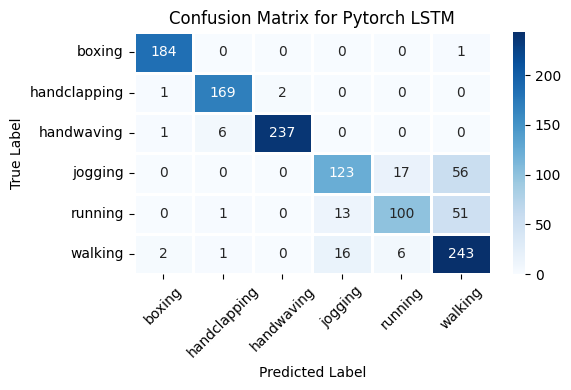

In [24]:
model = load_model("./saved_models/pytorch_lstm.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="Pytorch LSTM")

### Pytorch GRU

In [25]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"gru_pytorch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment-4'

#criterion
criterion = nn.CrossEntropyLoss()

In [26]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes, num_layers=num_layers, rnn_module='gru').to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [27]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

  3%|█▊                                                   | 1/30 [02:20<1:08:01, 140.75s/it]

Epoch 1/30
Train Loss: 1.1011, Train Accuracy: 0.4386
Eval Loss: 0.9839, Eval Accuracy: 0.4992
Learning Rate: 0.001000


  7%|███▌                                                 | 2/30 [04:42<1:06:00, 141.44s/it]

Epoch 2/30
Train Loss: 0.9067, Train Accuracy: 0.5402
Eval Loss: 0.8752, Eval Accuracy: 0.5732
Learning Rate: 0.001000


 10%|█████▎                                               | 3/30 [07:03<1:03:30, 141.13s/it]

Epoch 3/30
Train Loss: 0.7679, Train Accuracy: 0.6449
Eval Loss: 0.7114, Eval Accuracy: 0.6724
Learning Rate: 0.001000


 13%|███████                                              | 4/30 [09:25<1:01:15, 141.36s/it]

Epoch 4/30
Train Loss: 0.6236, Train Accuracy: 0.7217
Eval Loss: 0.5790, Eval Accuracy: 0.7593
Learning Rate: 0.001000


 17%|█████████▏                                             | 5/30 [11:46<58:52, 141.29s/it]

Epoch 5/30
Train Loss: 0.5424, Train Accuracy: 0.7530
Eval Loss: 0.5164, Eval Accuracy: 0.7618
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [14:07<56:29, 141.23s/it]

Epoch 6/30
Train Loss: 0.4334, Train Accuracy: 0.8055
Eval Loss: 0.4394, Eval Accuracy: 0.8073
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [16:28<54:06, 141.16s/it]

Epoch 7/30
Train Loss: 0.4236, Train Accuracy: 0.8081
Eval Loss: 0.4046, Eval Accuracy: 0.8146
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [18:49<51:44, 141.12s/it]

Epoch 8/30
Train Loss: 0.3859, Train Accuracy: 0.8250
Eval Loss: 0.4192, Eval Accuracy: 0.8138
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [21:10<49:23, 141.13s/it]

Epoch 9/30
Train Loss: 0.3666, Train Accuracy: 0.8341
Eval Loss: 0.3839, Eval Accuracy: 0.8309
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [23:31<47:01, 141.08s/it]

Epoch 10/30
Train Loss: 0.3457, Train Accuracy: 0.8407
Eval Loss: 0.3947, Eval Accuracy: 0.8415
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [25:54<44:52, 141.72s/it]

Epoch 11/30
Train Loss: 0.3005, Train Accuracy: 0.8618
Eval Loss: 0.3676, Eval Accuracy: 0.8520
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [28:16<42:30, 141.71s/it]

Epoch 12/30
Train Loss: 0.2936, Train Accuracy: 0.8640
Eval Loss: 0.3641, Eval Accuracy: 0.8382
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [30:37<40:06, 141.53s/it]

Epoch 13/30
Train Loss: 0.2790, Train Accuracy: 0.8683
Eval Loss: 0.3375, Eval Accuracy: 0.8626
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [32:58<37:42, 141.38s/it]

Epoch 14/30
Train Loss: 0.2792, Train Accuracy: 0.8665
Eval Loss: 0.3393, Eval Accuracy: 0.8553
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [35:19<35:20, 141.33s/it]

Epoch 15/30
Train Loss: 0.2649, Train Accuracy: 0.8787
Eval Loss: 0.3553, Eval Accuracy: 0.8488
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [37:40<32:57, 141.25s/it]

Epoch 16/30
Train Loss: 0.2512, Train Accuracy: 0.8815
Eval Loss: 0.3454, Eval Accuracy: 0.8593
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [40:04<30:44, 141.91s/it]

Epoch 17/30
Train Loss: 0.2374, Train Accuracy: 0.8888
Eval Loss: 0.3663, Eval Accuracy: 0.8528
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [42:25<28:19, 141.62s/it]

Epoch 18/30
Train Loss: 0.2352, Train Accuracy: 0.8904
Eval Loss: 0.3478, Eval Accuracy: 0.8537
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [44:47<25:58, 141.71s/it]

Epoch 19/30
Train Loss: 0.2325, Train Accuracy: 0.8878
Eval Loss: 0.3585, Eval Accuracy: 0.8528
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [47:08<23:36, 141.60s/it]

Epoch 20/30
Train Loss: 0.2191, Train Accuracy: 0.8974
Eval Loss: 0.3574, Eval Accuracy: 0.8528
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [49:30<21:14, 141.56s/it]

Epoch 21/30
Train Loss: 0.2120, Train Accuracy: 0.8994
Eval Loss: 0.3605, Eval Accuracy: 0.8602
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [51:51<18:51, 141.46s/it]

Epoch 22/30
Train Loss: 0.2110, Train Accuracy: 0.9016
Eval Loss: 0.3676, Eval Accuracy: 0.8585
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [54:12<16:29, 141.42s/it]

Epoch 23/30
Train Loss: 0.2026, Train Accuracy: 0.9045
Eval Loss: 0.3632, Eval Accuracy: 0.8593
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [56:33<14:08, 141.37s/it]

Epoch 24/30
Train Loss: 0.2040, Train Accuracy: 0.9045
Eval Loss: 0.3624, Eval Accuracy: 0.8593
Learning Rate: 0.000063


 83%|█████████████████████████████████████████████         | 25/30 [58:55<11:47, 141.54s/it]

Epoch 25/30
Train Loss: 0.1976, Train Accuracy: 0.9065
Eval Loss: 0.3633, Eval Accuracy: 0.8593
Learning Rate: 0.000063


 87%|█████████████████████████████████████████████       | 26/30 [1:01:16<09:25, 141.43s/it]

Epoch 26/30
Train Loss: 0.1913, Train Accuracy: 0.9071
Eval Loss: 0.3749, Eval Accuracy: 0.8561
Learning Rate: 0.000031


 90%|██████████████████████████████████████████████▊     | 27/30 [1:03:39<07:05, 141.89s/it]

Epoch 27/30
Train Loss: 0.1881, Train Accuracy: 0.9110
Eval Loss: 0.3739, Eval Accuracy: 0.8610
Learning Rate: 0.000031


 93%|████████████████████████████████████████████████▌   | 28/30 [1:06:01<04:43, 141.91s/it]

Epoch 28/30
Train Loss: 0.1892, Train Accuracy: 0.9104
Eval Loss: 0.3722, Eval Accuracy: 0.8553
Learning Rate: 0.000031


 97%|██████████████████████████████████████████████████▎ | 29/30 [1:08:22<02:21, 141.63s/it]

Epoch 29/30
Train Loss: 0.1828, Train Accuracy: 0.9134
Eval Loss: 0.3723, Eval Accuracy: 0.8618
Learning Rate: 0.000031


100%|████████████████████████████████████████████████████| 30/30 [1:10:44<00:00, 141.48s/it]

Epoch 30/30
Train Loss: 0.1816, Train Accuracy: 0.9132
Eval Loss: 0.3849, Eval Accuracy: 0.8585
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▂▄▆▆▇▇▇▇█████████████████████
eval_loss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇███████████████
train_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.85854
eval_loss,0.38488
learning_rate,3e-05
train_accuracy,0.91321


In [28]:
save_path = "./saved_models/pytorch_gru.pth"
torch.save(model, save_path)

/tmp/ipykernel_2731082/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


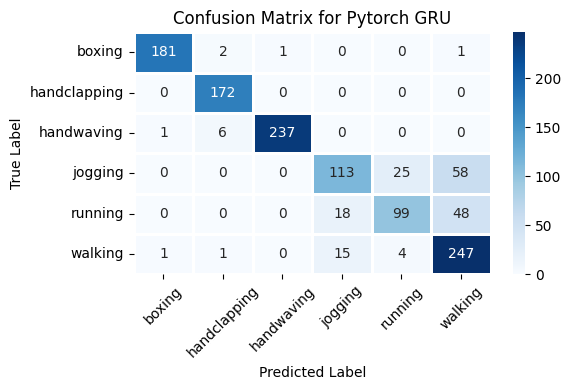

In [29]:
model = load_model("./saved_models/pytorch_gru.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="Pytorch GRU")

### ConvLSTM from Scratch

In [30]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
# hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"convlstm_scratch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment-4'

#criterion
criterion = nn.CrossEntropyLoss()

In [31]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes, num_layers=num_layers,rnn_module='convlstm').to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [32]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project,
    model_type='convlstm'
)

  3%|█▊                                                   | 1/30 [02:09<1:02:49, 129.97s/it]

Epoch 1/30
Train Loss: 0.9457, Train Accuracy: 0.5411
Eval Loss: 0.6948, Eval Accuracy: 0.6602
Learning Rate: 0.001000


  7%|███▌                                                 | 2/30 [04:20<1:00:41, 130.07s/it]

Epoch 2/30
Train Loss: 0.5538, Train Accuracy: 0.7506
Eval Loss: 0.5212, Eval Accuracy: 0.7593
Learning Rate: 0.001000


 10%|█████▌                                                 | 3/30 [06:29<58:23, 129.77s/it]

Epoch 3/30
Train Loss: 0.4619, Train Accuracy: 0.7937
Eval Loss: 0.4704, Eval Accuracy: 0.7967
Learning Rate: 0.001000


 13%|███████▎                                               | 4/30 [08:39<56:18, 129.96s/it]

Epoch 4/30
Train Loss: 0.4177, Train Accuracy: 0.8177
Eval Loss: 0.4830, Eval Accuracy: 0.7976
Learning Rate: 0.001000


 17%|█████████▏                                             | 5/30 [11:00<55:44, 133.79s/it]

Epoch 5/30
Train Loss: 0.3958, Train Accuracy: 0.8211
Eval Loss: 0.3932, Eval Accuracy: 0.8366
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [13:09<52:55, 132.32s/it]

Epoch 6/30
Train Loss: 0.3337, Train Accuracy: 0.8516
Eval Loss: 0.3735, Eval Accuracy: 0.8293
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [15:19<50:21, 131.37s/it]

Epoch 7/30
Train Loss: 0.2935, Train Accuracy: 0.8634
Eval Loss: 0.3268, Eval Accuracy: 0.8569
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [17:28<47:57, 130.81s/it]

Epoch 8/30
Train Loss: 0.2787, Train Accuracy: 0.8709
Eval Loss: 0.3422, Eval Accuracy: 0.8545
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [19:39<45:44, 130.71s/it]

Epoch 9/30
Train Loss: 0.2657, Train Accuracy: 0.8797
Eval Loss: 0.3399, Eval Accuracy: 0.8480
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [21:49<43:30, 130.51s/it]

Epoch 10/30
Train Loss: 0.2634, Train Accuracy: 0.8776
Eval Loss: 0.3497, Eval Accuracy: 0.8407
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [23:59<41:20, 130.53s/it]

Epoch 11/30
Train Loss: 0.2176, Train Accuracy: 0.9000
Eval Loss: 0.3335, Eval Accuracy: 0.8545
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [26:15<39:37, 132.06s/it]

Epoch 12/30
Train Loss: 0.1981, Train Accuracy: 0.9112
Eval Loss: 0.3079, Eval Accuracy: 0.8642
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [28:25<37:13, 131.38s/it]

Epoch 13/30
Train Loss: 0.1891, Train Accuracy: 0.9140
Eval Loss: 0.3255, Eval Accuracy: 0.8569
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [30:34<34:52, 130.78s/it]

Epoch 14/30
Train Loss: 0.1705, Train Accuracy: 0.9278
Eval Loss: 0.3332, Eval Accuracy: 0.8618
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [32:44<32:36, 130.44s/it]

Epoch 15/30
Train Loss: 0.1664, Train Accuracy: 0.9270
Eval Loss: 0.3531, Eval Accuracy: 0.8618
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [34:54<30:22, 130.19s/it]

Epoch 16/30
Train Loss: 0.1477, Train Accuracy: 0.9388
Eval Loss: 0.3461, Eval Accuracy: 0.8650
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [37:03<28:10, 130.05s/it]

Epoch 17/30
Train Loss: 0.1372, Train Accuracy: 0.9447
Eval Loss: 0.3479, Eval Accuracy: 0.8634
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [39:23<26:35, 132.93s/it]

Epoch 18/30
Train Loss: 0.1275, Train Accuracy: 0.9472
Eval Loss: 0.3522, Eval Accuracy: 0.8715
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [41:34<24:15, 132.28s/it]

Epoch 19/30
Train Loss: 0.1241, Train Accuracy: 0.9484
Eval Loss: 0.3571, Eval Accuracy: 0.8659
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [43:43<21:54, 131.48s/it]

Epoch 20/30
Train Loss: 0.1198, Train Accuracy: 0.9522
Eval Loss: 0.3920, Eval Accuracy: 0.8512
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [45:54<19:41, 131.23s/it]

Epoch 21/30
Train Loss: 0.1066, Train Accuracy: 0.9583
Eval Loss: 0.3628, Eval Accuracy: 0.8659
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [48:04<17:27, 130.89s/it]

Epoch 22/30
Train Loss: 0.0998, Train Accuracy: 0.9616
Eval Loss: 0.3636, Eval Accuracy: 0.8659
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [50:14<15:14, 130.57s/it]

Epoch 23/30
Train Loss: 0.0944, Train Accuracy: 0.9654
Eval Loss: 0.3698, Eval Accuracy: 0.8683
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [52:25<13:04, 130.69s/it]

Epoch 24/30
Train Loss: 0.0925, Train Accuracy: 0.9636
Eval Loss: 0.3669, Eval Accuracy: 0.8707
Learning Rate: 0.000063


 83%|█████████████████████████████████████████████         | 25/30 [54:37<10:55, 131.11s/it]

Epoch 25/30
Train Loss: 0.0897, Train Accuracy: 0.9659
Eval Loss: 0.3702, Eval Accuracy: 0.8715
Learning Rate: 0.000063


 87%|██████████████████████████████████████████████▊       | 26/30 [56:47<08:42, 130.74s/it]

Epoch 26/30
Train Loss: 0.0818, Train Accuracy: 0.9687
Eval Loss: 0.3764, Eval Accuracy: 0.8740
Learning Rate: 0.000031


 90%|████████████████████████████████████████████████▌     | 27/30 [58:56<06:31, 130.39s/it]

Epoch 27/30
Train Loss: 0.0785, Train Accuracy: 0.9709
Eval Loss: 0.3713, Eval Accuracy: 0.8764
Learning Rate: 0.000031


 93%|████████████████████████████████████████████████▌   | 28/30 [1:01:06<04:20, 130.15s/it]

Epoch 28/30
Train Loss: 0.0767, Train Accuracy: 0.9697
Eval Loss: 0.3836, Eval Accuracy: 0.8707
Learning Rate: 0.000031


 97%|██████████████████████████████████████████████████▎ | 29/30 [1:03:16<02:10, 130.13s/it]

Epoch 29/30
Train Loss: 0.0788, Train Accuracy: 0.9699
Eval Loss: 0.3822, Eval Accuracy: 0.8683
Learning Rate: 0.000031


100%|████████████████████████████████████████████████████| 30/30 [1:05:26<00:00, 130.87s/it]

Epoch 30/30
Train Loss: 0.0710, Train Accuracy: 0.9760
Eval Loss: 0.3889, Eval Accuracy: 0.8715
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▄▅▅▇▆▇▇▇▇▇█▇██████▇██████████
eval_loss,█▅▄▄▃▂▁▂▂▂▁▁▁▁▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.87154
eval_loss,0.38894
learning_rate,3e-05
train_accuracy,0.97602


In [33]:
save_path = "./saved_models/convlstm_scratch.pth"
torch.save(model, save_path)

/tmp/ipykernel_2731082/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


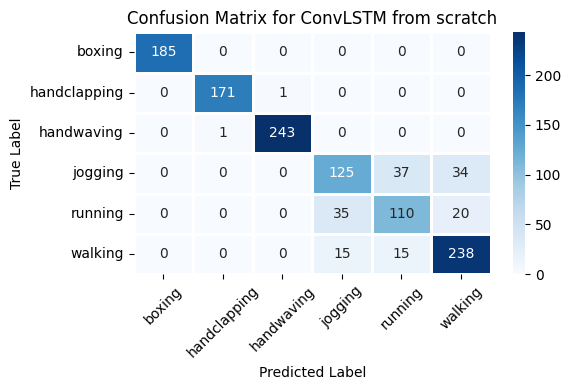

In [34]:
model = load_model("./saved_models/convlstm_scratch.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="ConvLSTM from scratch")